# Threshold Detection
## L2 (Geometric) + DSSIM (Perceptual) with Adaptive Candidate Detection

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import uniform_filter1d
from scipy.signal import find_peaks
import os
import glob
import re
from PIL import Image

from depth_panorama import rays_to_panorama

DATA_FOLDER = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\data\raw\t1-1"
PANO_FOLDER = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\data\panos"
OUTPUT_FOLDER = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\data\candidates"

os.makedirs(PANO_FOLDER, exist_ok=True)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

W, H = 64, 32
MAX_DIST = 10.0
SMOOTHING_WINDOW = 3
PROMINENCE_PERCENTILE = 75
ADAPTIVE_THRESHOLD_RATIO = 0.85

## Load Data

In [8]:
csv_files = sorted(
    glob.glob(os.path.join(DATA_FOLDER, "curve_*.csv")),
    key=lambda x: int(re.search(r'curve_(\d+)', x).group(1))
)
typology_id = os.path.basename(DATA_FOLDER)

if csv_files:
    print(f"Typology: {typology_id}")
    print(f"Total curves found: {len(csv_files)}\n")
    
    # validate
    for idx in [0, -1]:
        csv_file = csv_files[idx]
        curve_id = os.path.splitext(os.path.basename(csv_file))[0]
        data = np.loadtxt(csv_file, delimiter=",").T
        pano_files = sorted(glob.glob(os.path.join(PANO_FOLDER, f"{typology_id}_{curve_id}_*.png")))
        
        print(f"Curve: {curve_id}")
        print(f"  CSV frames: {len(data)} | Panoramas: {len(pano_files)} | Match: {len(data) == len(pano_files)}")
        if pano_files:
            print(f"  First pano: {os.path.basename(pano_files[0])} | Last pano: {os.path.basename(pano_files[-1])}")
        print()
else:
    print(f"ERROR: No CSV files in {DATA_FOLDER}")

Typology: t1-1
Total curves found: 100

Curve: curve_00
  CSV frames: 25 | Panoramas: 25 | Match: True
  First pano: t1-1_curve_00_000.png | Last pano: t1-1_curve_00_024.png

Curve: curve_99
  CSV frames: 27 | Panoramas: 27 | Match: True
  First pano: t1-1_curve_99_000.png | Last pano: t1-1_curve_99_026.png



## Generate Depth Panoramas

In [29]:
def generate_all_panoramas(data_folder, pano_folder):
    """Generate depth panoramas for all trajectories."""
    csv_files = sorted(
        glob.glob(os.path.join(data_folder, "curve_*.csv")),
        key=lambda x: int(re.search(r'curve_(\d+)', x).group(1))
    )
    typology_id = os.path.basename(data_folder)
    
    for csv_file in csv_files:
        curve_id = os.path.splitext(os.path.basename(csv_file))[0]
        data = np.loadtxt(csv_file, delimiter=",").T
        
        for i, rays in enumerate(data):
            pano = rays_to_panorama(rays, W=W, H=H, max_dist=MAX_DIST)
            # Frame indexing starts from 0
            pano_name = f"{typology_id}_{curve_id}_{i:03d}.png"
            Image.fromarray(pano).save(os.path.join(pano_folder, pano_name))
        
        print(f"Generated {len(data)} panoramas for {curve_id}")

generate_all_panoramas(DATA_FOLDER, PANO_FOLDER)

Generated 25 panoramas for curve_00
Generated 25 panoramas for curve_01
Generated 25 panoramas for curve_02
Generated 25 panoramas for curve_03
Generated 26 panoramas for curve_04
Generated 25 panoramas for curve_05
Generated 27 panoramas for curve_06
Generated 25 panoramas for curve_07
Generated 25 panoramas for curve_08
Generated 25 panoramas for curve_09
Generated 25 panoramas for curve_10
Generated 25 panoramas for curve_11
Generated 25 panoramas for curve_12
Generated 25 panoramas for curve_13
Generated 26 panoramas for curve_14
Generated 26 panoramas for curve_15
Generated 25 panoramas for curve_16
Generated 25 panoramas for curve_17
Generated 26 panoramas for curve_18
Generated 26 panoramas for curve_19
Generated 25 panoramas for curve_20
Generated 25 panoramas for curve_21
Generated 25 panoramas for curve_22
Generated 25 panoramas for curve_23
Generated 25 panoramas for curve_24
Generated 26 panoramas for curve_25
Generated 25 panoramas for curve_26
Generated 27 panoramas for c

## Compute Threshold Intensity

In [4]:
def compute_l2_intensity(pano_folder, curve_id, typology_id):
    """Geometric Intensity - L2 distance between consecutive panoramas."""
    pano_files = sorted(glob.glob(os.path.join(pano_folder, f"{typology_id}_{curve_id}_*.png")))
    panos = [np.array(Image.open(f)).astype(float) for f in pano_files]
    return np.array([np.linalg.norm(panos[i+1] - panos[i]) for i in range(len(panos) - 1)])

def compute_dssim_intensity(pano_folder, curve_id, typology_id):
    """Perceptual Intensity - Structural dissimilarity (1-SSIM)."""
    pano_files = sorted(glob.glob(os.path.join(pano_folder, f"{typology_id}_{curve_id}_*.png")))
    panos = [np.array(Image.open(f)).astype(float) for f in pano_files]
    return np.array([1 - ssim(panos[i], panos[i+1], data_range=255.0) for i in range(len(panos) - 1)])

def smooth_intensity(intensity, window=3):
    """Apply moving average smoothing."""
    return uniform_filter1d(intensity, size=window, mode='nearest')

def normalize_intensity(intensity):
    """Min-max normalization to [0, 1]."""
    return (intensity - intensity.min()) / (intensity.max() - intensity.min() + 1e-8)

def compute_intensities(pano_folder, curve_id, typology_id, l2_weight=0.5, dssim_weight=0.5):
    """Compute L2, DSSIM, and combined intensities."""
    l2_raw = compute_l2_intensity(pano_folder, curve_id, typology_id)
    dssim_raw = compute_dssim_intensity(pano_folder, curve_id, typology_id)
    
    l2_smooth = smooth_intensity(l2_raw, SMOOTHING_WINDOW)
    dssim_smooth = smooth_intensity(dssim_raw, SMOOTHING_WINDOW)
    
    l2_norm = normalize_intensity(l2_smooth)
    dssim_norm = normalize_intensity(dssim_smooth)
    
    combined = l2_weight * l2_norm + dssim_weight * dssim_norm
    
    return {
        'l2_norm': l2_norm,
        'dssim_norm': dssim_norm,
        'combined': combined
    }

## Threshold Candidate Detection

In [5]:
def detect_peaks_with_adaptive_neighbors(intensity, prominence_percentile=75, threshold_ratio=0.85):
    # local maxima
    prom_threshold = np.percentile(intensity, prominence_percentile)
    peaks, _ = find_peaks(intensity, prominence=prom_threshold * 0.3, distance=3)
    
    if len(peaks) == 0:
        return set()
    
    candidates = set()
    
    for peak in peaks:
        peak_value = intensity[peak]
        cutoff = peak_value * threshold_ratio
        
        candidates.add(peak)
        
        left = peak - 1
        while left >= 0 and intensity[left] >= cutoff:
            candidates.add(left)
            left -= 1
        
        right = peak + 1
        while right < len(intensity) and intensity[right] >= cutoff:
            candidates.add(right)
            right += 1
    
    return candidates

def detect_all_threshold_candidates(l2_intensity, dssim_intensity, prominence_percentile=75, threshold_ratio=0.85):

    l2_candidates = detect_peaks_with_adaptive_neighbors(l2_intensity, prominence_percentile, threshold_ratio)
    dssim_candidates = detect_peaks_with_adaptive_neighbors(dssim_intensity, prominence_percentile, threshold_ratio)
    
    all_candidates = l2_candidates | dssim_candidates
    
    return sorted(list(all_candidates))

## Visualization: First Curve Only

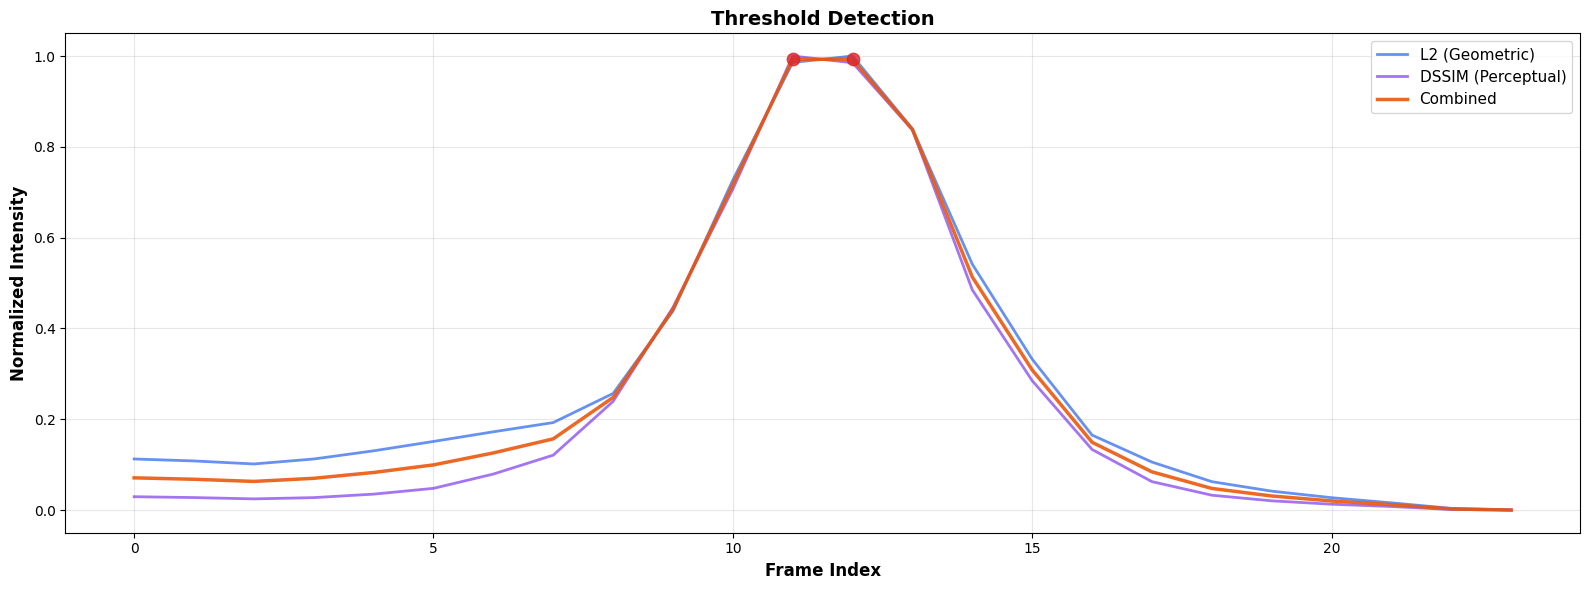

In [9]:
def plot_threshold_detection(intensities, candidate_frames, title):

    fig, ax = plt.subplots(figsize=(16, 6))
    
    ax.plot(intensities['l2_norm'], label='L2 (Geometric)', color='#2563eb', linewidth=2, alpha=0.7)
    ax.plot(intensities['dssim_norm'], label='DSSIM (Perceptual)', color='#7c3aed', linewidth=2, alpha=0.7)
    ax.plot(intensities['combined'], label='Combined', color='#ea580c', linewidth=2.5, alpha=0.9)
    
    for frame in candidate_frames:
        ax.scatter([frame], [intensities['combined'][frame]], 
                  color='#dc2626', s=80, zorder=5, marker='o', alpha=0.8)
    
    ax.set_xlabel('Frame Index', fontsize=12, fontweight='bold')
    ax.set_ylabel('Normalized Intensity', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.show()

csv_files = sorted(
    glob.glob(os.path.join(DATA_FOLDER, "curve_*.csv")),
    key=lambda x: int(re.search(r'curve_(\d+)', x).group(1))
)

if csv_files:
    csv_file = csv_files[0]
    curve_id = os.path.splitext(os.path.basename(csv_file))[0]
    typology_id = os.path.basename(DATA_FOLDER)
    full_id = f"{typology_id}_{curve_id}"
    
    intensities = compute_intensities(PANO_FOLDER, curve_id, typology_id)
    candidates = detect_all_threshold_candidates(
        intensities['l2_norm'], 
        intensities['dssim_norm'],
        PROMINENCE_PERCENTILE, 
        ADAPTIVE_THRESHOLD_RATIO
    )
    
    plot_threshold_detection(intensities, candidates, 'Threshold Detection')

## Batch Processing: All Trajectories

In [31]:
def process_trajectory(csv_file, pano_folder, typology_id):
    """
    Process one trajectory: compute intensities, detect all threshold candidates.
    """
    curve_id = os.path.splitext(os.path.basename(csv_file))[0]
    full_id = f"{typology_id}_{curve_id}"
    
    # Compute intensities
    intensities = compute_intensities(pano_folder, curve_id, typology_id)
    
    # Detect all threshold candidates from both L2 and DSSIM
    candidates = detect_all_threshold_candidates(
        intensities['l2_norm'],
        intensities['dssim_norm'],
        PROMINENCE_PERCENTILE,
        ADAPTIVE_THRESHOLD_RATIO
    )
    
    n_frames = len(intensities['combined']) + 1
    
    results = []
    for candidate_frame in candidates:
        window_start = max(0, candidate_frame - 3)
        window_end = min(n_frames - 1, candidate_frame + 3)
        
        results.append({
            'typology': typology_id,
            'curve': curve_id,
            'candidate_frame': candidate_frame,
            'window_start': window_start,
            'window_end': window_end
        })
    return results

def process_all_trajectories(data_folder, pano_folder, output_folder):
    csv_files = sorted(
        glob.glob(os.path.join(data_folder, "curve_*.csv")),
        key=lambda x: int(re.search(r'curve_(\d+)', x).group(1))
    )
    typology_id = os.path.basename(data_folder)

    
    all_results = []
    for csv_file in csv_files:
        results = process_trajectory(csv_file, pano_folder, typology_id)
        all_results.extend(results)
    
    # Save metadata
    metadata_path = os.path.join(output_folder, f"{typology_id}_thresholds.csv")
    df = pd.DataFrame(all_results)
    df.to_csv(metadata_path, index=False)
    
    print(f"Total threshold candidates detected: {len(all_results)}")
    
    return df

# Run batch processing
results_df = process_all_trajectories(DATA_FOLDER, PANO_FOLDER, OUTPUT_FOLDER)

Total threshold candidates detected: 253
